This notebook is for re-computing a subset of the master list that is in the NSA footprint, including K-corrections

In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import tempfile

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table, cosmology, constants as cnst
from astropy.visualization import hist as ahist

#SAGA imports
import hosts
import targeting
import kcorrect
from masterlist import masterlist as masterlist_module

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

# Load masterlist and associated bits 

In [4]:
masterlist = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_start=2)

units = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_end=2)
for c in masterlist.colnames:
    masterlist[c].unit = units[c][0].replace('#', '').replace('degrees', 'degree')

masterlist

RA,Dec,PGC#,NSAID,othername,vhelio,vhelio_err,distance,r,i,z,I,K
deg,deg,,,string,km / s,km / s,Mpc,mag,mag,mag,mag,mag
float64,float64,int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64
155.411800699,0.900255164384,--,464,--,897.302368164,190.000305176,12.9778122978,17.8465192987,17.8648594095,17.9443786814,--,--
175.827885017,0.212515965092,--,1212,--,149.585525513,95.0001525879,2.16116345011,13.2585573178,13.1388387662,12.8246870023,--,--
185.86139022,-0.411951305215,--,1398,--,108.256233215,70.0001144409,1.56371211242,16.7036302611,16.6973388716,16.7491024061,--,--
170.835578635,-3.13086875479,--,2996,--,2707.15625,160.000244141,39.3325045658,17.4986403253,17.3694737222,17.1953413751,--,--
179.301669033,-2.68650062571,--,3272,--,1536.73803711,142.500213623,22.2595972489,17.4616379866,17.5221982131,17.5233359465,--,--
178.369363427,-3.22968533309,--,3276,--,1586.27331543,142.500213623,22.9809618134,17.0503131048,16.9707919256,16.9346038,--,--
190.414321924,-1.44519645427,--,3526,--,146.170669556,87.5001296997,2.11179869823,7.73738497991,6.79136294621,7.93538874883,--,--
191.530258224,-3.26911585606,--,3537,--,1156.52880859,172.500274658,16.7390133251,17.396934302,17.1693904711,17.0419090105,--,13.254


In [5]:
nsa = table.Table(hosts.get_nsa())

In [6]:
#for NSA we have this round-about but simple way to get E(B-V) so we can get the S&F extinction
# See end of the notebook for proof that it works

# bands here are ugrizJHK
# these are Rx = Ax/E(B-V) for R_V~=3.1
sfd_Rx = np.array([5.155,3.793,2.751,2.086,1.479,0.902,0.576,0.367])
sandf_Rx = np.array([4.239, 3.303, 2.285, 1.698, 1.263, 0.709, 0.449,0.302])

nsa['E(B-V)'] = np.mean(np.array(nsa['EXTINCTION'])[:,-5:]/sfd_Rx[:5], axis=1)
nsa['A_ugrizJHK'] = (nsa['E(B-V)']*sandf_Rx[:, np.newaxis]).T

In [7]:
twomassxsc = masterlist_module.load_2mass_xsc('masterlist/2mass_xsc_irsa.tab')
twomassxsc

ra,dec,r_k20fe,j_m_k20fe,j_msig_k20fe,j_flg_k20fe,h_m_k20fe,h_msig_k20fe,h_flg_k20fe,k_m_k20fe,k_msig_k20fe,k_flg_k20fe,k_ba,k_phi,j_m_ext,j_msig_ext,h_m_ext,h_msig_ext,k_m_ext,k_msig_ext,cc_flg
float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,str1
161.902771,-1.185182,5.0,15.124,0.109,0,14.316,0.135,0,13.875,0.156,0,1.0,90,14.97,0.184,13.99,0.191,13.612,0.232,0
176.174164,24.901585,5.0,15.508,0.102,0,14.799,0.129,0,14.446,0.16,0,1.0,90,15.294,0.148,14.514,0.175,14.169,0.221,0
122.197197,-10.182686,5.0,15.573,0.138,0,--,--,--,14.198,0.19,0,1.0,90,15.298,0.197,14.979,0.0,13.986,0.291,0
67.092613,-39.653427,11.4,12.963,0.036,0,12.239,0.041,0,11.907,0.073,0,0.6,-40,12.775,0.041,12.136,0.047,11.844,0.079,0
58.178047,-48.642609,6.3,14.377,0.067,3,13.58,0.072,3,12.98,0.079,3,0.9,25,14.0,0.082,13.274,0.099,12.856,0.117,0
321.14444,-47.238235,6.4,14.754,0.095,0,13.984,0.112,0,13.49,0.105,0,1.0,90,14.476,0.132,13.606,0.149,13.304,0.168,0
73.605751,-22.839722,8.4,15.203,0.126,0,14.523,0.145,0,13.616,0.127,0,0.5,-55,15.014,0.189,14.385,0.23,13.241,0.167,0
163.984375,51.758099,5.0,15.346,0.096,0,14.75,0.153,0,14.043,0.118,0,1.0,90,15.114,0.14,14.727,0.278,13.788,0.172,0
312.112518,-65.092072,8.5,15.003,0.091,1,14.277,0.108,3,13.707,0.111,3,0.4,-35,14.922,0.164,14.077,0.162,13.261,0.133,0


## Build the sub-master list and add in the relevant photometry 

In [8]:
colstokeep = ['RA', 'Dec', 'NSAID', 'vhelio', 'vhelio_err', 'distance']
submaster0 = masterlist[~masterlist['NSAID'].mask][colstokeep]
submaster0

RA,Dec,NSAID,vhelio,vhelio_err,distance
deg,deg,,km / s,km / s,Mpc
float64,float64,int64,float64,float64,float64
155.411800699,0.900255164384,464,897.302368164,190.000305176,12.9778122978
175.827885017,0.212515965092,1212,149.585525513,95.0001525879,2.16116345011
185.86139022,-0.411951305215,1398,108.256233215,70.0001144409,1.56371211242
170.835578635,-3.13086875479,2996,2707.15625,160.000244141,39.3325045658
179.301669033,-2.68650062571,3272,1536.73803711,142.500213623,22.2595972489
178.369363427,-3.22968533309,3276,1586.27331543,142.500213623,22.9809618134
190.414321924,-1.44519645427,3526,146.170669556,87.5001296997,2.11179869823
191.530258224,-3.26911585606,3537,1156.52880859,172.500274658,16.7390133251


In [9]:
#integrate NSA SDSS mags

nsainfo = nsa[('NSAID', 'E(B-V)')]
for i, band in enumerate('FNugriz'):
    if band in ('F', 'N'):
        continue
    mag = 22.5-2.5*np.log10(nsa['SERSICFLUX'])[:, i]
    nsainfo[band] = mag
    nsainfo[band].unit = 'mag'
    
submaster = table.join(submaster0, nsainfo, 'NSAID')
submaster

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


RA,Dec,NSAID,vhelio,vhelio_err,distance,E(B-V),u,g,r,i,z
deg,deg,,km / s,km / s,Mpc,,mag,mag,mag,mag,mag
float64,float64,int64,float64,float64,float64,float64,float32,float32,float32,float32,float32
147.176446949,-0.354030416643,2,2051.19165039,132.500213623,29.7514014598,0.0877028543881,17.9815,16.8183,16.2982,16.0466,15.9215
146.193241319,-0.689391394961,6,1445.77697754,145.000228882,20.9358094095,0.0636514724703,17.024,15.9931,15.7017,15.5106,15.4168
146.007801384,-0.64225922322,7,1640.21911621,140.000228882,23.7665552411,0.0630527284911,15.6014,14.9153,15.0068,15.6666,15.5019
146.619063376,-0.434345458168,9,1986.12316895,132.500213623,28.8038324065,0.106928527026,17.0736,15.9022,15.4277,15.1936,14.9987
145.320962664,0.771102651396,30,2140.62915039,135.000213623,31.0538478259,0.114671165201,18.7395,17.6063,17.1605,16.9516,16.7769
145.513690377,0.336451585096,32,2082.18920898,132.500213623,30.0,0.0995307787189,13.2757,11.9934,11.3445,11.0006,10.7516
146.265781145,1.23041252815,43,2077.90454102,135.000213623,30.1404117443,0.160540565768,19.4772,18.2563,17.7993,17.5686,17.3586
146.045441016,0.179766406149,48,3532.24023438,182.500274658,51.4263961604,0.140434637517,18.0851,16.9846,16.4694,16.3201,16.0847


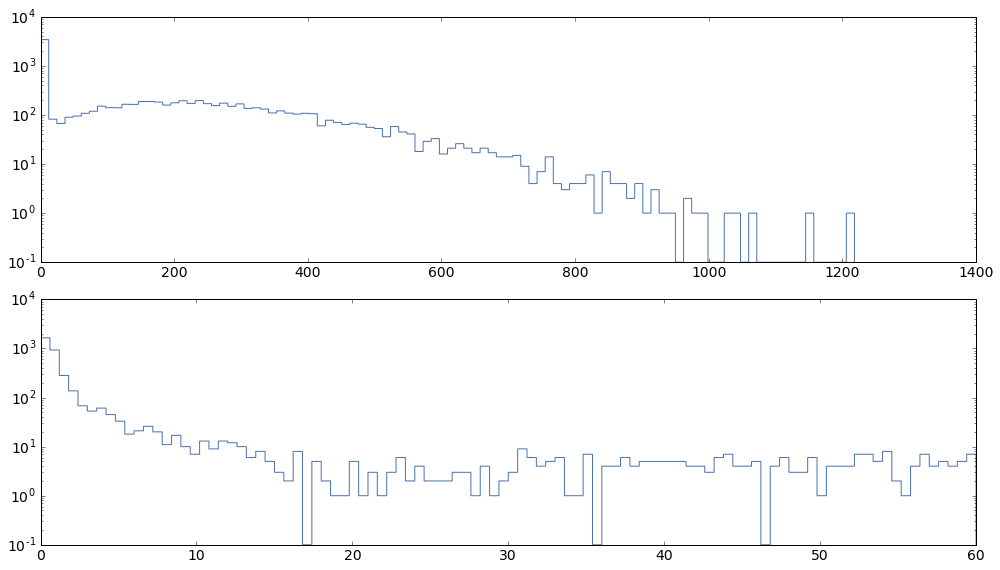

In [10]:
#integrate 2MASS JHK
scsubm = SkyCoord(submaster['RA'], submaster['Dec'])
sc2mass = SkyCoord(twomassxsc['ra'], twomassxsc['dec'], unit=u.deg)

idx, d2d, _ = scsubm.match_to_catalog_sky(sc2mass)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.hist(d2d.arcsec, histtype='step',bins=100, log=True)
ax2.hist(d2d.arcsec, histtype='step',bins=100, range=(0,60), log=True)

fig.tight_layout()

Why are there so many NSA objects not in 2MASS? For now we'll just accept these but mask them

In [11]:
submaster['dist_2MASS_NSA'] = d2d

In [12]:
idx2mass = twomassxsc[idx]

for band in 'jhk':
    twomass_col = '{}_m_ext'.format(band)
    twomass_err_col = '{}_msig_ext'.format(band)
    
    submaster[band.upper()] = idx2mass[twomass_col]
    submaster[band.upper()+"_err"] = idx2mass[twomass_err_col]

In [13]:
#add extinction for each, and also the z for use with kcorrect
for i, bandnm in enumerate('ugrizJHK'):
    submaster['A_'+bandnm] = submaster['E(B-V)']*sandf_Rx[i]
    # not that this is *not* the real absolute magnitude yet
    submaster[bandnm+'_extcorr'] = submaster[bandnm] + submaster['A_'+bandnm]
    
submaster['z_kcorr'] = (u.Quantity(submaster['vhelio'])/cnst.c).decompose()

In [27]:
#tosend = submaster['NSAID', 'u_extcorr', 'g_extcorr', 'r_extcorr', 'i_extcorr', 'z_extcorr', 
#                   'J_extcorr', 'H_extcorr', 'K_extcorr', 'z_kcorr']
#tosend = submaster['NSAID', 'J_extcorr', 'H_extcorr', 'K_extcorr',
#                   'J_err', 'H_err', 'K_err', 'z_kcorr']

In [28]:
#tosend.write('submaster_to_be_kcorred', format='ascii', delimiter=' ')
#!mv submaster_to_be_kcorred /Users/erik/Dropbox/

Now in IDL run:

```
IDL> readcol, u,g,r,i,z,J,H,K, ue,ge,re,ie,ze ,Je,He,Ke, z_kcorr
IDL> kcorrect, [u,g,r,i,z,J,H,K], [ue,ge,re,ie,ze,Je,He,Ke], z_kcorr, out, filterlist=['sdss_u0.par','sdss_g0.par','sdss_r0.par','sdss_i0.par','sdss_z0.par','twomass_J.par', 'twomass_H.par','twomass_Ks.par'],/magnitude
IDL> forprint, out, textout = 'kcorr_out'
```

In [18]:
kcorrect.load_templates()

def load_filters_by_name(bandnms, band_shift=0.0, verbose=False):
    with tempfile.NamedTemporaryFile() as ntf:
        ntf.write('KCORRECT_DIR\n')
        for bandnm in bandnms:
            ntf.write('data/filters/{}\n'.format(bandnm))

        ntf.seek(0)
        if verbose:
            !cat $ntf.name
        kcorrect.load_filters(ntf.name, band_shift)
    
ugrizJHK_filters = ['sdss_{}0.par'.format(bandnm) for bandnm in 'ugriz']
ugrizJHK_filters.extend(['twomass_{}.par'.format(bandnm) for bandnm in ('J','H','Ks')])
load_filters_by_name(ugrizJHK_filters)

KCORRECT_DIR
data/filters/sdss_u0.par
data/filters/sdss_g0.par
data/filters/sdss_r0.par
data/filters/sdss_i0.par
data/filters/sdss_z0.par
data/filters/twomass_J.par
data/filters/twomass_H.par
data/filters/twomass_Ks.par


In [21]:
redshift = 0.03077382
maggies = [1.144068e-08, 5.262234e-08, 8.210213e-08, 8.744532e-08, 1.017738e-07,1,2,3]
maggies_ivar = [6.216309e+16, 3.454767e+17, 1.827409e+17, 1.080889e+16, 3163927000000000.0,1,2,3]

In [22]:
coeffs = kcorrect.fit_nonneg(redshift, maggies, maggies_ivar)

In [23]:
rm = kcorrect.reconstruct_maggies(coeffs)

In [27]:
rm

array([  3.07738204e-02,   1.44426542e-08,   5.28384945e-08,
         8.09117253e-08,   9.51680335e-08,   1.10408642e-07,
         1.34550049e-07,   1.54223102e-07,   1.33128964e-07], dtype=float32)

In [26]:
kcorrect.reconstruct_maggies??

In [30]:
load_filters_by_name(ugrizJHK_filters, band_shift=0.1)
rm0 = kcorrect.reconstruct_maggies(coeffs, redshift=0.)

KCORRECT_DIR
data/filters/sdss_u0.par
data/filters/sdss_g0.par
data/filters/sdss_r0.par
data/filters/sdss_i0.par
data/filters/sdss_z0.par
data/filters/twomass_J.par
data/filters/twomass_H.par
data/filters/twomass_Ks.par


In [29]:
-2.5*np.log10(rm[1:]/rm0[1:]).astype(float)

array([ -3.17973830e-01,  -2.27918401e-01,  -1.61477383e-01,
         1.88272024e-04,  -9.79175512e-02])

In [41]:
kcorrect.load_filters??

# Appendix/consistency checks

## Is the difference between vdist and z significant enough to worry about? 

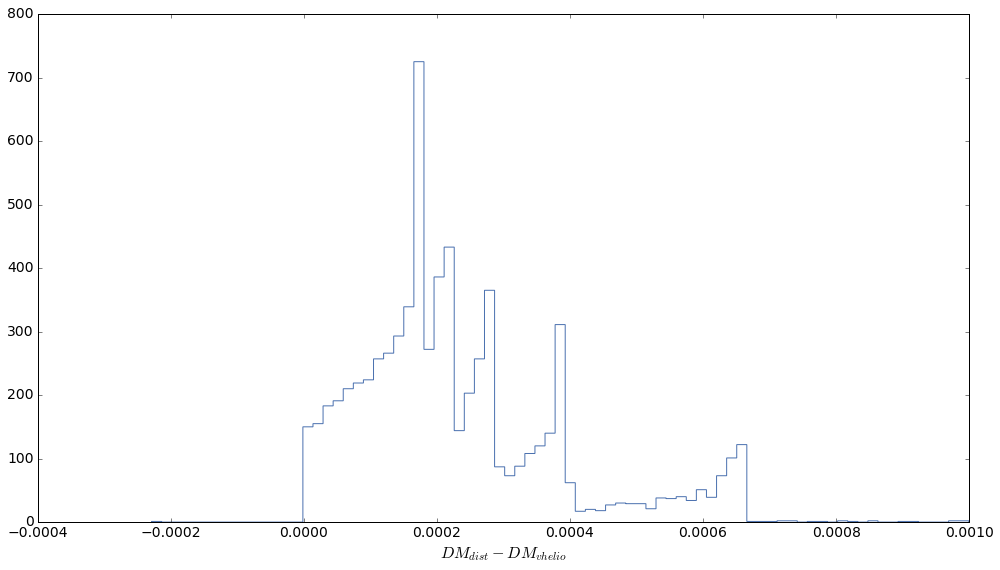

In [113]:
z = (u.Quantity(submaster['vhelio'])/cnst.c).decompose()
dmz = Distance(cosmology.WMAP9.luminosity_distance(z), allow_negative=True).distmod
dmd = Distance(submaster['distance']).distmod
dd = dmd - dmz

ahist(dd[np.isfinite(dd)], bins='knuth', histtype='step', range=(-.0003, .001))
plt.xlabel('$DM_{dist} - DM_{vhelio}$')
plt.tight_layout()

Looks like totally-ignorable

##  Checking assumptions about extintion

In [120]:
# bands here are ugrizJHK

# these are Rx = Ax/E(B-V) for R_V~=3.1
sfd_Rx = np.array([5.155,3.793,2.751,2.086,1.479,0.902,0.576,0.367])
sandf_Rx = np.array([4.239, 3.303, 2.285, 1.698, 1.263, 0.709, 0.449,0.302])

In [131]:
np.array(nsa['EXTINCTION'])[:,-5:]/sfd_Rx[:5]

array([[ 0.05472223,  0.05472223,  0.05472223,  0.05472223,  0.05472223],
       [ 0.0521579 ,  0.05215789,  0.05215789,  0.05215789,  0.05215789],
       [ 0.08770286,  0.08770285,  0.08770285,  0.08770286,  0.08770285],
       ..., 
       [ 0.05120614,  0.05120613,  0.05120613,  0.05120613,  0.05120613],
       [ 0.06441259,  0.06441259,  0.06441258,  0.06441258,  0.06441259],
       [ 0.03289034,  0.03289033,  0.03289033,  0.03289033,  0.03289033]])

Looks like that's a consistent way to get E(B-V)